In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
generate_loss_plots = False 

In [4]:
train = np.load('./MNIST_training_set.npy', allow_pickle=True).item() # Get items
test = np.load('./MNIST_test_set.npy', allow_pickle=True).item() # Get items
X_train, y_train = train['features'], train['labels'] # Split data
X_test, y_test = test['features'], test['labels'] # Split data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # Print Shape of data

(2000, 256) (2000,) (500, 256) (500,)


In [5]:
pca = PCA() # Initialize
pca.fit(X_train); # Fit on training data

In [6]:
def dataModeApproximation(pca_model, X_data, N_comp):
    # Reduce data and generate approximation
    all_components = np.copy(pca_model.components_) # Get all components
    X_pca = pca_model.transform(X_data) # Transform Data
    X_reduced = np.dot(X_data - pca_model.mean_, 
                       pca_model.components_[:N_comp].T) # Reduce Data
    pca_model.components_[N_comp:] = 0 # Zero out non-desired components
    X_approx = pca_model.inverse_transform(X_pca) # Inverse transform
    pca_model.components_ = all_components # Reset components
    
    # Return
    return X_reduced, X_approx # Return data

In [7]:
N = 16 # Components to keep
X_train_red, X_train_red_approx = dataModeApproximation(pca, X_train, N) # 16 mode approx
_, X_train_32_approx = dataModeApproximation(pca, X_train, 2*N) # 32 mode approx
_, X_train_64_approx = dataModeApproximation(pca, X_train, 4*N) # 64 mode approx
X_train_red.shape

(2000, 16)

In [15]:
'''
Helper Function to Plot. Takes in list of data to plot in gridspace, number of digits to plot,
and list titles to use for each grid
'''
def plotModeApproximations(X_list, N_digits, titles):
    if not isinstance(X_list, list): # Convert to list if needed
        X_list = list(X_list)
    if not isinstance(titles, list): 
        titles = list(titles)
        
    # Parameters based on number of plots
    L = len(X_list) # Number of plots
    N = int(np.sqrt(N_digits)) # Length of squares
    grid_x = int(max(1, N // 4)) # Width, max at 4 plots
    grid_y = int(L if L <= 4 else 4) # Height
    p_width = N * grid_y # Plot width
    p_height = N * grid_x # Plot height
    
    # Generate Plot
    fig = plt.figure(figsize=(p_width, p_height))
    gs0 = gs.GridSpec(grid_x, grid_y)
    for idx, X in enumerate(X_list): # Iterate over data included
        gsx = gs.GridSpecFromSubplotSpec(N, N, subplot_spec = gs0[idx])
        for i in range(N): # Iterate through digits
            for j in range(N): # Iterate through digits
                ax = fig.add_subplot(gsx[i, j])
                ax.imshow(X[(N)*i+j,:].reshape((16, 16)), cmap="Greys")
                ax.axis("off")
        # Dummy axis to add titles
        ax = fig.add_subplot(gsx[:])
        ax.axis('off')
        ax.set_title(titles[idx])

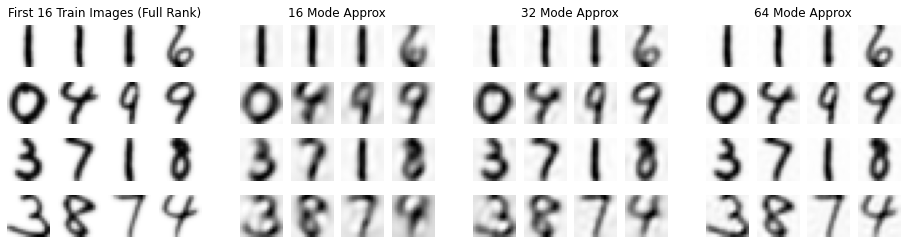

In [16]:
plotModeApproximations([X_train, X_train_red_approx, X_train_32_approx, X_train_64_approx], 16, 
                        ['First 16 Train Images (Full Rank)', '16 Mode Approx','32 Mode Approx', '64 Mode Approx'])
plt.savefig('./Approximations_Of_Training_Images.png', bbox_inches='tight')

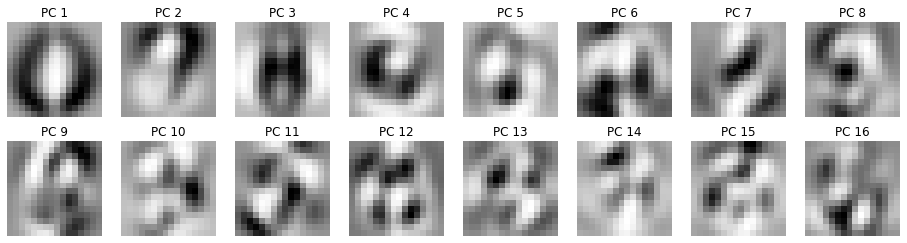

In [13]:
# Plot first 16 PCA Modes
first_modes = pca.components_ # Extract the first modes
fig, ax = plt.subplots(2, 8, figsize=(16,4)) # Four x four space
for i in range(2):
    for j in range(8):
        ax[i, j].imshow(first_modes[(8 * i) + j, :].reshape((16, 16)), cmap="Greys") # Plot component
        ax[i, j].axis('off')
        ax[i, j].set_title('PC ' + str((8 * i) + j + 1), fontsize=12) # Set title
plt.savefig('./First_16_Principal_Components.png', bbox_inches='tight')
plt.show()

In [14]:
# Get number of modes for specified variances (Using PCA Values)
ratio_sums = np.cumsum(pca.explained_variance_ratio_)
num_comps = lambda vec, pct: np.where(vec >= pct)[0].min() + 1 # Helper lambda function
var_60 = num_comps(ratio_sums, 0.60) # 60% Variance
var_80 = num_comps(ratio_sums, 0.80) # 80% Variance
var_90 = num_comps(ratio_sums, 0.90) # 90% Variance
var_95 = num_comps(ratio_sums, 0.95) # 95% Variance
var_99 = num_comps(ratio_sums, 0.99) # 99% Variance
print(var_60, var_80, var_90, var_95, var_99) # Print Results

6 13 23 34 65


In [15]:
# Frobenius norms
frob_norms = np.cumsum(pca.singular_values_**2)**0.5 / \
                np.sum(pca.singular_values_**2)**0.5
frob_norms_individual = (pca.singular_values_**2)**0.5 / \
                np.sum(pca.singular_values_**2)**0.5
f_60 = num_comps(frob_norms, 0.6)
f_80 = num_comps(frob_norms, 0.8)
f_90 = num_comps(frob_norms, 0.9)
f_95 = num_comps(frob_norms, 0.95)
f_99 = num_comps(frob_norms, 0.99)
print(f_60, f_80, f_90, f_95, f_99)

3 7 14 23 51


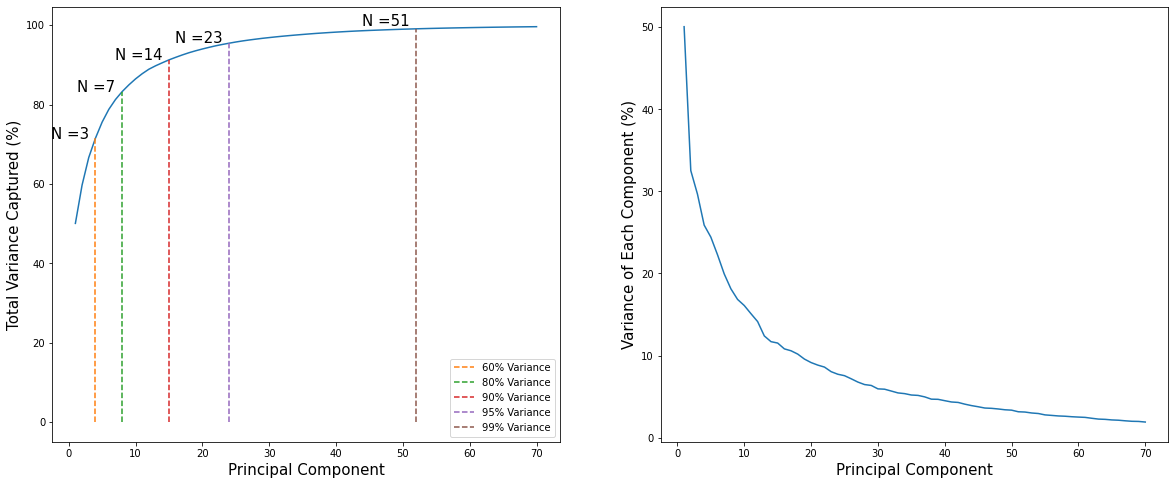

In [16]:
# Generate some variance plots
comp_plot = 70
x_dat = np.arange(1, ratio_sums.shape[0] + 1)[:comp_plot] # x axis values
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Cumulative variance with labels
ax[0].plot(x_dat, 100 * frob_norms[:comp_plot])
ax[0].plot([f_60 + 1, f_60 + 1], [0, 100 * frob_norms[f_60]], '--',
          label='60% Variance') # Plot 80% Variance Line
ax[0].annotate('N =' + str(f_60), (f_60, 100*frob_norms[f_60]), 
               fontsize=15, ha='right') # Label f_80
ax[0].plot([f_80 + 1, f_80 + 1], [0, 100 * frob_norms[f_80]], '--',
          label='80% Variance') # Plot 80% Variance Line
ax[0].annotate('N =' + str(f_80), (f_80, 100*frob_norms[f_80]), 
               fontsize=15, ha='right') # Label f_80
ax[0].plot([f_90 + 1, f_90 + 1], [0, 100 * frob_norms[f_90]], '--',
          label='90% Variance')
ax[0].annotate('N =' + str(f_90), (f_90, 100*frob_norms[f_90]), 
               fontsize=15, ha='right') # Label
ax[0].plot([f_95 + 1, f_95 + 1], [0, 100 * frob_norms[f_95]], '--',
          label='95% Variance')
ax[0].annotate('N =' + str(f_95), (f_95, 100*frob_norms[f_95]), 
               fontsize=15, ha='right') # Label
ax[0].plot([f_99 + 1, f_99 + 1], [0, 100 * frob_norms[f_99]], '--',
          label='99% Variance')
ax[0].annotate('N =' + str(f_99), (f_99, 100*frob_norms[f_99]), 
               fontsize=15, ha='right', va='bottom') # Label
ax[0].set_xlabel('Principal Component', fontsize=15)
ax[0].set_ylabel('Total Variance Captured (%)', fontsize=15)
ax[0].legend()

# Variance of each component
ax[1].plot(x_dat, 100 * frob_norms_individual[:comp_plot])
ax[1].set_xlabel('Principal Component', fontsize=15)
ax[1].set_ylabel('Variance of Each Component (%)', fontsize=15)
plt.savefig('./Component_Variance_Graphs.png', bbox_inches='tight')
plt.show()

In [17]:
'''
Function that extracts specified digits from MNIST dataset and creates
a dimensionally reduced dataset using only two specified digits. Takes in data, labels,
number of PCA components to use, and the digits to use. Uses 1, 2 if no digits are
specified.
'''
def reducedBinaryDigitSet(pca_model, N_comp, X_data, y_data, digits=None):
    if digits is None: # Use all digits if not specified
        digits = [1,2]
        print('No Digits Specified - Assuming 1, 2')
    
    # Update data
    idxs_to_use = np.where(np.isin(y_data, digits))[0] # Find rows of matching entries
    y_labs_new = y_data[idxs_to_use] # Get labels
    X_data_new = X_data[idxs_to_use, :] # Get Data
    y_labs_new = np.where(y_labs_new == digits[0], -1, 1) # Normalize classifier
    
    # Reduce new X_data using previous function
    X_data_new_red, _ = dataModeApproximation(pca_model, X_data_new, N_comp) 
    
    # Return data
    return X_data_new_red, y_labs_new

In [18]:
'''
Function to generate RidgeRegression Model. Takes in tuple of train data/labels,
tuple of test data/labels, and parameters needed to execute reducedBinaryDataset and
dataModeApproximation. Returns model, mean square error and percent prediction for train and 
test. Regression value of < 0 is a prediction of the negative value, > 0 is a 
prediction of the positive value. Optionally can specify a random state to control results
'''
def ridgeClassifierForDigits(train_dat, test_dat, pca_model, N_comp, digits=None, 
                             alphas=2**np.linspace(-4, 20, 1000), random_state=None):
    # Separate/Reduce Data
    X_train, y_train = train_dat[0], train_dat[1]
    X_test, y_test = test_dat[0], test_dat[1]
    X_train_red, y_train_red = reducedBinaryDigitSet(pca_model, N_comp, X_train, 
                                                     y_train, digits=digits)
    X_test_red, y_test_red = reducedBinaryDigitSet(pca_model, N_comp, X_test, 
                                                   y_test, digits=digits)
    
    # Create ridge model using that searches for best alpha, predict on data
    ridge_model = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error') # use MSE for scoring
    ridge_model.fit(X_train_red, y_train_red) # Fit on training data
    X_train_red, y_train_red = shuffle(X_train_red, y_train_red,
                                      random_state=random_state) # Shuffle after fitting
    y_train_pred = ridge_model.predict(X_train_red) # Predict on train data
    y_test_pred = ridge_model.predict(X_test_red) # Predict on test_data
    
    # Calculate metrics
    A_train = np.hstack((np.ones((X_train_red.shape[0], 1)), X_train_red)) # Add vector of ones to make A
    A_test = np.hstack((np.ones((X_test_red.shape[0], 1)), X_test_red)) # Add vector of ones to make A
    beta_vec = np.hstack((ridge_model.intercept_, ridge_model.coef_)) # Build beta vector
    train_mse = 1/(len(y_train_red)) * np.linalg.norm(A_train.dot(beta_vec) - y_train_red, ord=2)**2 # Train MSE
    test_mse = 1/(len(y_test_red)) * np.linalg.norm(A_test.dot(beta_vec) - y_test_red, ord=2)**2 # Test MSE
    y_train_pred_binary = np.where(y_train_pred <= 0, -1, 1) # Convert to classes
    y_test_pred_binary = np.where(y_test_pred <= 0, -1, 1) # Convert to absolutes
    train_correct = np.count_nonzero(y_train_pred_binary == y_train_red) / len(y_train_pred) # % correct train
    test_correct = np.count_nonzero(y_test_pred_binary == y_test_red) / len(y_test_pred) # % correct test
        
    return (train_mse, train_correct, test_mse, test_correct), ridge_model
    

In [19]:
# Run models
N = 16 # Components to use
train = (X_train, y_train)
test = (X_test, y_test)
res18, m18 = ridgeClassifierForDigits(train, test, pca, N, digits=[1,8]) # digits [1,8]
res38, m38 = ridgeClassifierForDigits(train, test, pca, N, digits=[3,8]) # digits [3,8]
res27, m27 = ridgeClassifierForDigits(train, test, pca, N, digits=[2,7]) # digits [2,7]
print(res18) 
print(res38)
print(res27)

(0.07543256880324288, 0.9912087912087912, 0.08258337249382386, 0.9791666666666666)
(0.18197394765741923, 0.9829059829059829, 0.2600071200977306, 0.9166666666666666)
(0.09243856143549345, 0.9943019943019943, 0.1324834891141817, 0.9795918367346939)


In [34]:
# Run for different N values and record error
N_plot = 50 # How many components to calculate for
#if generate_loss_plots:
components = np.arange(1, N_plot + 1)
train_mse = {'[1,8]':[], '[3,8]': [], '[2,7]':[]} # Training MSE
testing_mse = {'[1,8]':[], '[3,8]': [], '[2,7]':[]} # Test MSE
for c in components:
    res18, _ = ridgeClassifierForDigits(train, test, pca, c, digits=[1,8]) # digits [1,8]
    res38, _ = ridgeClassifierForDigits(train, test, pca, c, digits=[3,8]) # digits [3,8]
    res27, _ = ridgeClassifierForDigits(train, test, pca, c, digits=[2,7]) # digits [2,7]
    train_mse['[1,8]'].append(res18[0]), testing_mse['[1,8]'].append(res18[2])
    train_mse['[3,8]'].append(res38[0]), testing_mse['[3,8]'].append(res38[2])
    train_mse['[2,7]'].append(res27[0]), testing_mse['[2,7]'].append(res27[2])
print(train_mse)

{'[1,8]': [0.2752923838250753, 0.23338258606615503, 0.19895567092220146, 0.19833977524373478, 0.16553204378741704, 0.1497153609063726, 0.1497392376876457, 0.14319814036187953, 0.12584786197624703, 0.09115823771673813, 0.09115605068854733, 0.07622286727638633, 0.07636426874915381, 0.07554465427897741, 0.07527824099105727, 0.07543256880324287, 0.07467824114939109, 0.06898211586633582, 0.06922476218727944, 0.06484892757749017, 0.06291454046873511, 0.05946090505058604, 0.056146267149795634, 0.05489680708374881, 0.054819838617705556, 0.05424321579347754, 0.05455702116130575, 0.054076180295838557, 0.05426491020711834, 0.05376559468680379, 0.053486139800428094, 0.05330579282565341, 0.053072649968320965, 0.052690594564091406, 0.05124362453732996, 0.05074215129691784, 0.04934853829672996, 0.04940350663516554, 0.04888081275096736, 0.04901684200923134, 0.04901122810227349, 0.048919495376052245, 0.049036795976688356, 0.04894688016722476, 0.04830592223677643, 0.048353743890730674, 0.048332021604738

<function show at 0x7f523b2abdc0>

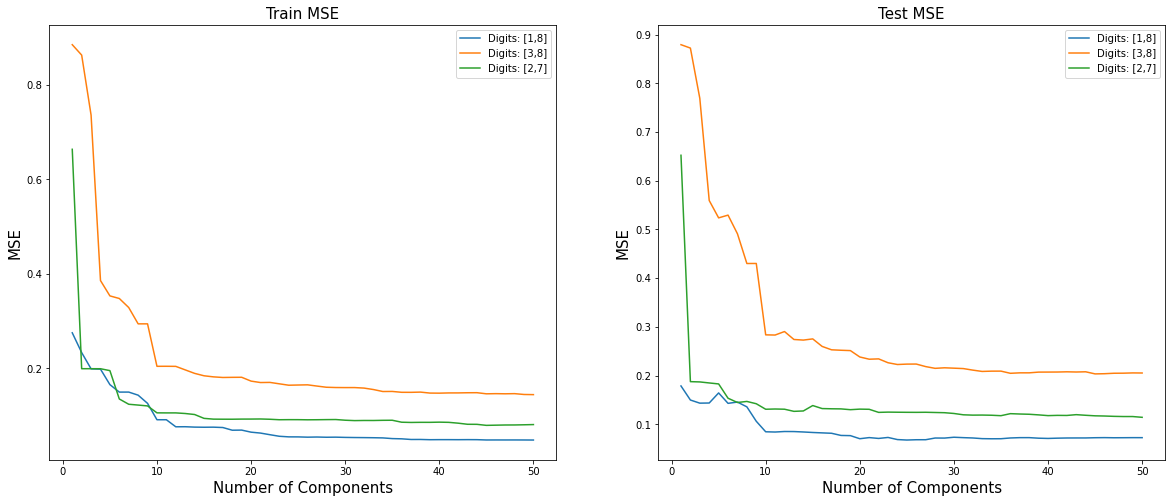

In [35]:
# Plot the results
#if generate_loss_plots:
# Train
fig, ax = plt.subplots(1, 2, figsize=(20,8))
for k, train_v in train_mse.items():
    ax[0].plot(components, train_v, label='Digits: ' + k)
ax[0].set_xlabel('Number of Components', fontsize=15)
ax[0].set_ylabel('MSE', fontsize=15)
ax[0].set_title('Train MSE', fontsize=15)
ax[0].legend()

# Test
for k, test_v in testing_mse.items():
    ax[1].plot(components, test_v, label='Digits: ' + k)
ax[1].set_xlabel('Number of Components', fontsize=15)
ax[1].set_ylabel('MSE', fontsize=15)
ax[1].set_title('Test MSE', fontsize=15)
ax[1].legend()
plt.savefig('./Train_Test_MSE.png', bbox_inches='tight')
plt.show